In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from preprocessing import preprocess
import h5py
import urllib.request
import re
from maayanlab_bioinformatics.harmonization import ncbi_genes
from get_symbol import get_symbol
from prediction_pipeline import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso 

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading gene expression data

In [2]:
f = pd.read_csv('GSE156063_swab_gene_counts.csv.gz')
f.index = f.iloc[:, 0] # Make ENSG genes as row indexing 
f = f.iloc[:, 1:] # Remove first index column 

In [3]:
f

,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1534,621,1903,2796,416,15,263,834,58,177,...,264,53,578,626,134,1,56,99,297,83
ENSG00000000419,153,123,221,344,112,20,45,116,26,46,...,83,97,110,132,57,15,19,1,33,19
ENSG00000000457,295,185,457,626,170,79,164,174,57,95,...,105,170,129,128,66,36,26,31,121,61
ENSG00000000460,75,108,292,367,49,31,37,57,44,35,...,21,117,44,68,27,9,1,0,24,60
ENSG00000000938,19,471,1843,284,38,539,495,9,1528,1409,...,139,87,49,133,62,4,3,1,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000287856,40,77,189,62,95,156,61,23,24,70,...,7,72,14,25,5,0,9,0,7,6
ENSG00000288258,0,21,2,41,34,0,5,7,5,0,...,8,3,0,3,0,0,0,2,2,5
ENSG00000288380,34,0,0,5,0,3,3,1,11,0,...,0,0,0,0,17,8,0,1,11,2


In [4]:
# Normalize data 
norm = preprocess(f)

In [5]:
# Convert Ensembl number index to gene symbol
norm = get_symbol(norm)
norm

,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
TSPAN6,9.750394,8.431520,8.536410,9.230869,8.419235,5.561493,8.145934,9.775714,6.667802,7.745806,...,8.180515,5.026008,9.526165,9.177776,7.941530,4.877658,7.910921,9.262038,10.033367,7.944507
DPM1,6.127114,6.002366,5.249229,5.956564,6.316461,5.903046,5.496793,6.622060,5.609731,5.970437,...,6.457110,5.953559,6.916508,6.714337,6.672384,7.162435,6.332690,5.013840,6.716536,5.725258
SCYL3,7.153231,6.591814,6.363691,6.867613,7.007707,7.547516,7.490316,7.278342,6.637774,6.962121,...,6.819049,6.785380,7.175186,6.659617,6.882470,8.217438,6.770866,7.830724,8.741190,7.488884
C1orf112,4.997992,5.799738,5.683124,6.048044,5.018780,6.428549,5.156712,5.526507,6.292580,5.570527,...,4.446830,6.219428,5.485222,5.672800,5.617461,6.589548,3.500152,0.000000,6.209080,7.462111
FGR,2.879951,8.019425,8.486833,5.658744,4.616182,9.779217,9.013250,2.671251,10.250164,9.878493,...,7.235374,5.791892,5.649619,6.727083,6.785820,5.786167,4.190450,5.014101,5.410709,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000287856,3.994869,5.268032,4.989002,3.355198,6.069830,8.355011,6.030361,4.080079,5.548841,6.573128,...,3.151128,5.504255,3.904021,4.138380,3.920471,4.872641,5.486766,5.008913,4.683105,4.091037
ENSG00000288258,0.381253,3.128959,0.741362,2.778832,4.494295,3.556651,2.403892,2.499549,3.556651,1.414968,...,3.304010,1.703540,1.119629,1.761382,2.820633,4.873239,3.494636,5.611814,3.624522,3.854520
ENSG00000288380,3.758763,0.257046,0.517748,0.877175,1.011474,4.267958,1.980540,1.130407,4.523328,1.416092,...,1.469524,0.989427,1.119629,0.900702,5.093880,6.588714,3.495341,5.365951,5.207784,2.973531
TMX2-CTNND1,5.747578,4.250350,5.048791,5.911258,4.322945,7.930172,4.013606,5.675303,5.923891,3.251837,...,4.621659,3.555366,3.804682,4.604726,7.120856,4.873239,3.495786,5.009396,2.869194,5.103178


# Convert gene x sample --> pathway x sample 

For each Gene Ontology library in Enrichr, convert it to a binary matrix of pathways x genes. 
Then multiply the matrix of pathways x genes by the above genes x samples to get a pathways x samples matrix.

In [6]:
libraries = ['GO_Biological_Process_2018', 'GO_Molecular_Function_2018', 'GO_Cellular_Component_2018']

In [7]:
pathway_by_sample = h5py.File("pathway_by_sample", "w")

In [10]:
for lib in libraries: 
    function_to_genes, gene_set = gene_set_dictionaries(lib)
    common_genes = list(set(gene_set) & set(norm.index)) # genes in common
    binary_matrix = gs_binary_matrix(function_to_genes, gene_set).loc[common_genes]
    df = norm.loc[common_genes]
    path_by_sample = (binary_matrix.T).dot(df)
    print(lib)
    display(path_by_sample)
    
    # Save in HDF file 
    pathway_list = (pd.DataFrame(path_by_sample.index)).values.astype("S").tolist()
    sample_list = (pd.DataFrame(path_by_sample.columns)).values.astype("S").tolist()
    group = pathway_by_sample.create_group("covid_" + lib)
    group.create_dataset("path_by_sample", data=path_by_sample)
    group.create_dataset("pathways", data=pathway_list)
    group.create_dataset("samples", data=sample_list)
    
c

GO_Biological_Process_2018


,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
positive regulation of posttranscriptional gene silencing (GO:0060148),92.403124,91.803923,90.408107,92.272488,89.512727,91.977834,95.177372,93.000909,92.354177,92.496478,...,89.374007,94.360504,88.159007,92.036904,82.906768,86.875113,94.163442,86.222016,85.227638,89.509470
regulation of cell cycle process (GO:0010564),544.592341,531.757964,538.437853,543.650227,548.619968,524.032346,523.057107,551.836291,526.269462,521.794014,...,547.908004,548.811089,545.341086,546.371466,567.884167,535.993118,549.072569,525.751064,535.617460,541.572617
angiotensin-activated signaling pathway (GO:0038166),18.608192,22.192448,22.393063,21.750741,20.014000,23.887462,19.423255,21.481542,23.624945,20.402958,...,18.772204,18.155777,21.104695,19.849010,20.278852,23.420169,21.219611,17.166243,17.513518,24.404331
"DNA-templated transcription, termination (GO:0006353)",688.946530,670.060064,675.887585,699.374031,715.817525,698.906427,668.406859,694.902239,684.266453,679.738960,...,706.266683,734.976164,693.863632,697.493212,701.390549,684.181428,696.320259,661.735561,695.052642,679.479678
regulation of protein sumoylation (GO:0033233),95.869233,95.513737,96.749490,96.079362,96.331329,99.309556,96.879286,95.013113,94.885336,97.762834,...,93.103278,98.459807,95.266319,95.735906,95.265908,92.383091,89.045882,97.696497,89.855800,94.915308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
positive regulation of mitochondrial membrane potential (GO:0010918),38.117682,36.880828,38.925782,39.512722,39.130491,38.190123,37.176227,37.966058,38.580408,40.217247,...,41.940605,43.953018,39.911323,37.522298,42.034118,38.597475,38.414493,32.006915,41.574373,42.075670
tRNA aminoacylation for protein translation (GO:0006418),155.987883,150.690669,148.838156,157.532172,156.116621,154.975375,146.278225,159.329171,151.036872,136.473229,...,153.756345,165.055093,154.919974,153.082214,160.529492,150.919396,167.232358,147.493998,159.170220,152.570717
tryptophan metabolic process (GO:0006568),42.734931,48.445733,39.351476,41.208123,42.413839,47.449349,49.493664,42.264581,47.837214,48.160434,...,49.202244,47.315982,40.450486,44.839124,43.069262,42.231976,40.361596,40.276208,44.822249,47.818598
guanosine-containing compound metabolic process (GO:1901068),104.789489,108.793161,106.321513,105.657146,108.514045,114.223894,109.066253,102.818830,107.553791,112.439664,...,109.535443,110.251027,104.790788,106.820905,109.030350,105.558267,104.903598,110.540551,105.769311,101.142411


GO_Molecular_Function_2018


,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
semaphorin receptor activity (GO:0017154),78.192094,74.798443,75.944865,76.177348,73.330858,61.579192,72.519598,76.145131,77.606030,72.362170,...,72.880794,65.038787,70.043273,74.818351,59.542041,66.033079,63.831439,63.589774,66.930104,68.748910
7SK snRNA binding (GO:0097322),42.439109,42.258923,40.949545,42.546971,42.631629,42.772688,44.047928,41.940519,44.412506,46.513162,...,42.829744,47.947246,44.449273,44.001870,41.185092,43.843290,41.669201,44.502850,41.717511,44.331202
androgen receptor binding (GO:0050681),281.777452,298.199142,285.728147,287.360436,299.699389,295.542915,293.027770,290.937175,281.059593,285.881698,...,296.637218,302.536014,292.484487,297.852273,305.093335,285.937317,295.085635,280.384006,282.953357,293.455769
transcription regulatory region DNA binding (GO:0044212),2095.217540,2111.175938,2071.320154,2098.412469,2140.863907,2156.805491,2146.750221,2092.141405,2151.168487,2109.655909,...,2127.719707,2163.557638,2088.019827,2084.585988,2125.230181,2105.410428,2106.500678,2026.059490,2064.947214,2089.962371
protein phosphatase inhibitor activity (GO:0004864),115.631068,108.232735,109.875271,113.011675,119.058289,108.587976,112.565453,112.680255,104.740827,105.140064,...,118.447699,112.663049,121.290951,108.699410,122.825395,110.841174,115.329115,113.490131,119.420306,113.481007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ras GTPase binding (GO:0017016),1167.442866,1165.860370,1154.383987,1184.899179,1156.964634,1166.211739,1162.378290,1166.558120,1145.549461,1133.085707,...,1147.126598,1165.410913,1149.453137,1158.191458,1151.410355,1143.889619,1141.539792,1136.157655,1135.425549,1168.688788
"transcriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific binding (GO:0001077)",897.731751,905.803093,887.396674,892.504604,922.559684,949.133161,935.016943,890.658421,897.887320,910.077451,...,913.061185,908.644352,893.254130,890.055469,929.651288,929.117266,948.053522,869.074268,904.128005,886.240149
ubiquitin-like protein ligase binding (GO:0044389),1980.068067,1977.906491,1970.901349,1991.400808,2017.679527,2069.858750,2009.886652,1998.274004,1994.063007,1969.986905,...,2029.513632,2042.428146,2009.071593,1986.535896,2032.347463,1972.807203,2001.707727,1935.228068,2007.326336,1967.546926
sodium ion transmembrane transporter activity (GO:0015081),301.886416,307.555423,303.137515,315.868119,293.660218,264.762777,316.859737,322.177720,319.097998,316.945251,...,293.185976,289.241501,297.618213,303.453227,267.023247,296.991413,256.536624,311.636452,301.158731,335.307467


GO_Cellular_Component_2018


,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
platelet dense granule (GO:0042827),113.933615,100.582269,104.062791,109.726568,108.870995,102.088702,108.286577,114.688533,103.463679,98.496471,...,100.808862,103.587866,111.083154,110.234442,103.973698,100.349168,101.935002,104.682539,106.225782,119.081129
chromatoid body (GO:0033391),30.661913,34.367153,30.268814,33.760776,28.894008,33.876800,35.252581,32.753348,43.363942,33.352650,...,29.340288,32.798229,32.311546,29.277832,29.430997,33.496301,35.523756,32.066111,33.141543,33.809169
Golgi trans cisterna (GO:0000138),50.703582,47.954057,51.006821,51.596079,48.767868,50.696196,47.796299,48.450200,47.941224,49.644442,...,47.139047,43.953627,49.541636,51.342890,46.325363,46.664096,50.972780,50.594352,48.680307,51.930300
elongin complex (GO:0070449),30.076489,26.952031,26.478325,28.941021,28.980007,30.704652,27.750332,27.398230,25.702468,25.718816,...,27.313290,26.751462,29.115153,25.905686,29.598671,32.430498,30.489615,31.659200,30.782561,25.211505
telomerase holoenzyme complex (GO:0005697),145.716228,146.715809,143.771946,148.303716,151.397366,140.608150,140.054825,147.624016,145.229985,140.755992,...,149.125618,161.302488,148.185448,148.116076,156.255844,142.273009,146.481628,140.187101,153.797071,140.663904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mitochondrial intermembrane space (GO:0005758),298.289437,280.401641,286.969744,289.458560,313.244113,323.492800,280.333421,298.290539,280.780329,273.515240,...,303.713543,305.427903,318.521351,296.662628,323.905342,285.498574,308.618918,291.239294,320.963697,293.461534
cytosolic large ribosomal subunit (GO:0022625),518.939767,505.548524,515.077868,501.168108,580.082660,528.509749,492.651423,532.540841,438.976233,447.254722,...,527.184101,595.884406,546.909460,516.073953,569.854958,508.243550,572.585424,436.755081,560.899100,491.982358
ribosome (GO:0005840),596.298868,572.765457,589.531981,581.228749,661.490918,608.332690,575.099949,609.842596,514.398354,535.938051,...,609.862978,672.455285,625.985825,596.390615,640.369394,596.141704,651.475006,537.988218,646.422696,562.347788
recycling endosome (GO:0055037),750.266043,733.972052,731.455883,754.972793,737.250375,755.428718,747.992601,747.361760,752.043773,758.446686,...,751.478966,757.336001,753.883754,760.612700,734.786634,731.380038,745.612430,714.396157,747.028124,738.114374


# Ground truth data

In [6]:
gr_truth = pd.read_csv("GSE156063_series_matrix.txt", sep='\t')
gr_truth

,!Sample_title,RR057e_00202_N05_S78,RR057e_00080_H20_S312,RR057e_00287_L09_S140,RR057e_00753_G10_S151,RR057e_00751_C10_S147,RR057e_00520_I04_S57,RR057e_00505_K04_S59,RR057i_00083_K09_S139,RR057e_00764_F16_S246,...,RR057i_00136_J07_S106,RR057i_00137_L07_S108,RR057i_00156_N13_S206,RR057i_00158_F15_S230,RR057e_00719_H04_S56,RR057e_00721_L04_S60,RR057e_00731_H08_S120,RR057e_00728_N06_S94,RR057i_00067_C05_S67,RR057i_00116_E21_S325
0,!Sample_geo_accession,GSM4721578,GSM4721579,GSM4721580,GSM4721581,GSM4721582,GSM4721583,GSM4721584,GSM4721585,GSM4721586,...,GSM4721802,GSM4721803,GSM4721804,GSM4721805,GSM4721806,GSM4721807,GSM4721808,GSM4721809,GSM4721810,GSM4721811
1,!Sample_status,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,...,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020
2,!Sample_submission_date,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,...,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020
3,!Sample_last_update_date,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,...,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020
4,!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
5,!Sample_channel_count,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,!Sample_source_name_ch1,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,...,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab
7,!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
8,!Sample_characteristics_ch1,gender: F,gender: M,gender: F,gender: F,gender: F,gender: F,gender: M,gender: F,gender: F,...,gender: M,gender: F,gender: M,gender: F,gender: M,gender: M,gender: F,gender: F,gender: F,gender: F
9,!Sample_characteristics_ch1,age: 62,age: 81,age: 76,age: 36,age: 58,age: 79,age: 89,age: 63,age: 71,...,age: 44,age: 55,age: 31,age: 54,age: 40,age: 27,age: 63,age: 40,age: 44,age: 54


In [7]:
gr_truth = gr_truth.iloc[10, 1:]
idx = [ "_".join(i.split("_")[:2]) for i in gr_truth.index ]
gr_truth.index = idx
gr_truth

RR057e_00202    sars-cov-2 rpm: NEG
RR057e_00080    sars-cov-2 rpm: NEG
RR057e_00287    sars-cov-2 rpm: NEG
RR057e_00753    sars-cov-2 rpm: POS
RR057e_00751    sars-cov-2 rpm: POS
                       ...         
RR057e_00721    sars-cov-2 rpm: POS
RR057e_00731    sars-cov-2 rpm: POS
RR057e_00728    sars-cov-2 rpm: POS
RR057i_00067    sars-cov-2 rpm: POS
RR057i_00116    sars-cov-2 rpm: NEG
Name: 10, Length: 234, dtype: object

In [8]:
gr_truth = pd.DataFrame(gr_truth).loc[norm.columns]
test = [ 1 if res[-3:] == 'POS' else 0 for res in gr_truth.iloc[:, 0] ]
gr_truth.iloc[:, 0] = test
gr_truth.columns = ["Truth"]
gr_truth

,Truth
RR057e_00202,0
RR057e_00080,0
RR057e_00287,0
RR057e_00753,1
RR057e_00751,1
...,...
RR057e_00721,1
RR057e_00731,1
RR057e_00728,1
RR057i_00067,1


# Combine data

In [9]:
pathway_by_sample = h5py.File("pathway_by_sample", "r+")
def h5py_to_list(lst):
    return [ str(i)[3:-2] for i in lst ]

In [10]:
frames = []
covid_keys = [ k for k in list(pathway_by_sample.keys()) if 'covid' in k ]
for key in covid_keys:
    key_matrix = pathway_by_sample[key]['path_by_sample']
    key_pathways = h5py_to_list(pathway_by_sample[key]['pathways'])
    key_samples = h5py_to_list(pathway_by_sample[key]['samples'])
    key_df = pd.DataFrame(key_matrix, index=key_pathways, columns=key_samples)
    frames.append(key_df)
go_df = pd.concat(frames)
display(go_df)

,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
positive regulation of posttranscriptional gene silencing (GO:0060148),92.403124,91.803923,90.408107,92.272488,89.512727,91.977834,95.177372,93.000909,92.354177,92.496478,...,89.374007,94.360504,88.159007,92.036904,82.906768,86.875113,94.163442,86.222016,85.227638,89.509470
regulation of cell cycle process (GO:0010564),544.592341,531.757964,538.437853,543.650227,548.619968,524.032346,523.057107,551.836291,526.269462,521.794014,...,547.908004,548.811089,545.341086,546.371466,567.884167,535.993118,549.072569,525.751064,535.617460,541.572617
angiotensin-activated signaling pathway (GO:0038166),18.608192,22.192448,22.393063,21.750741,20.014000,23.887462,19.423255,21.481542,23.624945,20.402958,...,18.772204,18.155777,21.104695,19.849010,20.278852,23.420169,21.219611,17.166243,17.513518,24.404331
"DNA-templated transcription, termination (GO:0006353)",688.946530,670.060064,675.887585,699.374031,715.817525,698.906427,668.406859,694.902239,684.266453,679.738960,...,706.266683,734.976164,693.863632,697.493212,701.390549,684.181428,696.320259,661.735561,695.052642,679.479678
regulation of protein sumoylation (GO:0033233),95.869233,95.513737,96.749490,96.079362,96.331329,99.309556,96.879286,95.013113,94.885336,97.762834,...,93.103278,98.459807,95.266319,95.735906,95.265908,92.383091,89.045882,97.696497,89.855800,94.915308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ras GTPase binding (GO:0017016),1167.442866,1165.860370,1154.383987,1184.899179,1156.964634,1166.211739,1162.378290,1166.558120,1145.549461,1133.085707,...,1147.126598,1165.410913,1149.453137,1158.191458,1151.410355,1143.889619,1141.539792,1136.157655,1135.425549,1168.688788
"transcriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific binding (GO:0001077)",897.731751,905.803093,887.396674,892.504604,922.559684,949.133161,935.016943,890.658421,897.887320,910.077451,...,913.061185,908.644352,893.254130,890.055469,929.651288,929.117266,948.053522,869.074268,904.128005,886.240149
ubiquitin-like protein ligase binding (GO:0044389),1980.068067,1977.906491,1970.901349,1991.400808,2017.679527,2069.858750,2009.886652,1998.274004,1994.063007,1969.986905,...,2029.513632,2042.428146,2009.071593,1986.535896,2032.347463,1972.807203,2001.707727,1935.228068,2007.326336,1967.546926
sodium ion transmembrane transporter activity (GO:0015081),301.886416,307.555423,303.137515,315.868119,293.660218,264.762777,316.859737,322.177720,319.097998,316.945251,...,293.185976,289.241501,297.618213,303.453227,267.023247,296.991413,256.536624,311.636452,301.158731,335.307467


## Linear (OLS) Regression Model
Testing using K-folds and cross-validation

In [30]:
# define the pipeline
steps = [('pca', PCA(n_components=0.95)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, bp_df.T, gr_truth.values.ravel(), scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.835 (0.070)


In [56]:
# For combined GO matrix 
# define the pipeline
steps = [('pca', PCA(n_components=0.95)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, go_df.T, gr_truth.values.ravel(), scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.848 (0.066)


## Lasso model

### Nested cross-validation to optimize lasso model

In [13]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
from matplotlib import pyplot as plt

In [12]:
X, y = go_df.T, gr_truth.values.ravel()

0.9481481481481482
0.95
0.8714285714285714
0.9327731092436975
0.9307692307692307
0.9615384615384616
0.7936507936507937
0.8809523809523809
0.9642857142857143
0.8412698412698412
AUC: 0.907 (0.055)


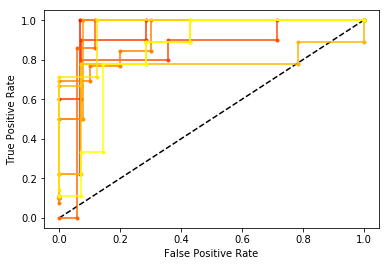

In [38]:
# generate no skill prediction
ns_probs = [0 for n in y]
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black')

# configure the cross-validation procedure 
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

# enumerate splits 
outer_results = []
summary = []
count = 0
for train_idx, test_idx in cv_outer.split(X):
    count += 1
    # split data 
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    # configure the cross-validation procedure 
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model 
    lassocv = LassoCV(alphas=None, cv=cv_inner, max_iter=100000)
    result = lassocv.fit(X_train, y_train)
    # evaluate model on the holdout dataset 
    yhat = result.predict(X_test)
    # evaluate model
    fpr, tpr, _ = roc_curve(y_test, yhat)
    auc_ = metrics.auc(fpr, tpr)
    outer_results.append(auc_)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.', color=cmap(count/10))
    # report progress
    print(auc_)
    # add parameters to summary 
    summary.append(result.coef_)
# summarize estimated model performance
print('AUC: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()

In [38]:
# get summary table 
sum_df = pd.DataFrame(summary, columns=X.columns)

In [40]:
summary_cols = (pd.DataFrame(X.columns)).values.astype("S").tolist()
pathway_by_sample.create_dataset("summaries", data=sum_df)
pathway_by_sample.create_dataset("summaries_columns", data=summary_cols)

<HDF5 dataset "summaries_columns": shape (6700, 1), type "|S206">

In [45]:
pathway_by_sample.close()

In [41]:
sum_df

,positive regulation of posttranscriptional gene silencing (GO:0060148),regulation of cell cycle process (GO:0010564),angiotensin-activated signaling pathway (GO:0038166),"DNA-templated transcription, termination (GO:0006353)",regulation of protein sumoylation (GO:0033233),regulation of cellular response to stress (GO:0080135),potassium ion import (GO:0010107),protein complex disassembly (GO:0043241),protein insertion into mitochondrial membrane (GO:0051204),regulation of mitotic spindle assembly (GO:1901673),...,mannosyltransferase activity (GO:0000030),sialyltransferase activity (GO:0008373),UDP-xylosyltransferase activity (GO:0035252),small protein activating enzyme activity (GO:0008641),phosphatidylinositol phosphate binding (GO:1901981),Ras GTPase binding (GO:0017016),"transcriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific binding (GO:0001077)",ubiquitin-like protein ligase binding (GO:0044389),sodium ion transmembrane transporter activity (GO:0015081),annealing helicase activity (GO:0036310)
0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
1,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
2,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
3,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
4,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
5,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,...,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
6,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
7,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
8,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
9,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0


In [43]:
new_sum_df = sum_df.loc[:, (sum_df != 0).any(axis=0)]

In [44]:
new_sum_df

,cellular transition metal ion homeostasis (GO:0046916),cellular protein complex assembly (GO:0043623),peptidyl-lysine modification (GO:0018205),regulation of canonical Wnt signaling pathway (GO:0060828),nervous system development (GO:0007399),epidermis development (GO:0008544),negative regulation of cellular process (GO:0048523),regulation of acute inflammatory response (GO:0002673),T cell activation (GO:0042110),cell morphogenesis involved in neuron differentiation (GO:0048667),...,"transcription factor activity, RNA polymerase II core promoter proximal region sequence-specific binding (GO:0000982)",actin filament binding (GO:0051015),cation channel activity (GO:0005261),ligand-gated ion channel activity (GO:0015276),kinase binding (GO:0019900),acetylglucosaminyltransferase activity (GO:0008375),purine ribonucleoside triphosphate binding (GO:0035639),"transcriptional repressor activity, RNA polymerase II transcription regulatory region sequence-specific binding (GO:0001227)",G-protein coupled receptor binding (GO:0001664),cytokine receptor binding (GO:0005126)
0,-0.000558,0.000988,0.000564,0.002316,-0.000439,-0.000000,0.001224,0.000000,-0.000000,0.000000,...,-0.002431,0.000000,-0.000000,0.00000,-0.000251,-0.000656,-0.000000,-0.000000,-0.000688,-0.000000
1,-0.000000,0.000000,0.000000,0.001469,-0.000000,-0.000449,0.000000,0.000000,-0.000000,0.000016,...,-0.000000,0.000000,-0.000000,0.00000,-0.001616,-0.000000,-0.000000,-0.001315,-0.000000,-0.000000
2,-0.000000,0.000000,0.000000,0.002701,-0.000000,-0.000000,0.000000,0.000000,-0.000199,0.000000,...,-0.000000,0.000000,-0.000000,0.00000,-0.000941,-0.000000,-0.000000,-0.000405,-0.000000,-0.000000
3,-0.000000,0.000000,0.000000,0.000916,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,...,-0.000000,0.000000,-0.000000,0.00000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
4,-0.000000,0.001459,0.000000,0.002857,-0.000000,-0.001115,0.000000,0.000000,-0.000000,0.000000,...,-0.000728,0.000000,-0.000000,0.00000,-0.001058,-0.000000,-0.000000,-0.002227,-0.000000,-0.000000
5,0.000000,0.000000,0.000000,0.002061,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,...,-0.000000,0.000000,-0.000000,0.00000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
6,-0.000000,0.000000,0.000000,0.001967,-0.000000,-0.000136,0.000000,0.000000,-0.000000,0.000000,...,-0.000000,0.000000,-0.000000,0.00000,-0.000353,-0.000000,-0.000000,-0.002303,-0.000000,-0.000000
7,-0.000000,0.000739,0.000000,0.003771,-0.000042,-0.000000,0.000000,0.001454,-0.000000,0.000000,...,-0.000000,0.000000,-0.001834,0.00035,-0.000000,-0.000000,-0.000000,-0.000000,-0.002475,-0.000000
8,-0.000000,0.000000,0.000000,0.001978,-0.000000,-0.000354,0.000217,0.000896,-0.000000,0.000000,...,-0.000573,0.000000,-0.000000,0.00000,-0.000162,-0.000000,-0.000094,-0.001630,-0.000000,-0.000102
9,-0.000000,0.001204,0.000000,0.001925,-0.000093,-0.000091,0.000000,0.000000,-0.000000,0.000000,...,-0.000000,0.000329,-0.000000,0.00000,-0.000239,-0.000000,-0.001195,-0.002048,-0.000000,-0.000000


## Get pathway lambda data

In [11]:
list(pathway_by_sample.keys())

['covid_GO_Biological_Process_2018',
 'covid_GO_Cellular_Component_2018',
 'covid_GO_Molecular_Function_2018',
 'summaries',
 'summaries_columns']

In [17]:
summaries_columns = [str(pathway)[3:-2] for pathway in pathway_by_sample['summaries_columns']]

In [21]:
summaries = pd.DataFrame(pathway_by_sample['summaries'], columns=summaries_columns)

In [22]:
summaries

,positive regulation of posttranscriptional gene silencing (GO:0060148),regulation of cell cycle process (GO:0010564),angiotensin-activated signaling pathway (GO:0038166),"DNA-templated transcription, termination (GO:0006353)",regulation of protein sumoylation (GO:0033233),regulation of cellular response to stress (GO:0080135),potassium ion import (GO:0010107),protein complex disassembly (GO:0043241),protein insertion into mitochondrial membrane (GO:0051204),regulation of mitotic spindle assembly (GO:1901673),...,mannosyltransferase activity (GO:0000030),sialyltransferase activity (GO:0008373),UDP-xylosyltransferase activity (GO:0035252),small protein activating enzyme activity (GO:0008641),phosphatidylinositol phosphate binding (GO:1901981),Ras GTPase binding (GO:0017016),"transcriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific binding (GO:0001077)",ubiquitin-like protein ligase binding (GO:0044389),sodium ion transmembrane transporter activity (GO:0015081),annealing helicase activity (GO:0036310)
0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
1,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
2,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
3,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
4,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
5,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,...,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
6,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
7,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
8,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
9,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0


In [23]:
new_df = summaries.loc[:, (summaries != 0).any(axis=0)]

In [24]:
new_df

,cellular transition metal ion homeostasis (GO:0046916),cellular protein complex assembly (GO:0043623),peptidyl-lysine modification (GO:0018205),regulation of canonical Wnt signaling pathway (GO:0060828),nervous system development (GO:0007399),epidermis development (GO:0008544),negative regulation of cellular process (GO:0048523),regulation of acute inflammatory response (GO:0002673),T cell activation (GO:0042110),cell morphogenesis involved in neuron differentiation (GO:0048667),...,"transcription factor activity, RNA polymerase II core promoter proximal region sequence-specific binding (GO:0000982)",actin filament binding (GO:0051015),cation channel activity (GO:0005261),ligand-gated ion channel activity (GO:0015276),kinase binding (GO:0019900),acetylglucosaminyltransferase activity (GO:0008375),purine ribonucleoside triphosphate binding (GO:0035639),"transcriptional repressor activity, RNA polymerase II transcription regulatory region sequence-specific binding (GO:0001227)",G-protein coupled receptor binding (GO:0001664),cytokine receptor binding (GO:0005126)
0,-0.000558,0.000988,0.000564,0.002316,-0.000439,-0.000000,0.001224,0.000000,-0.000000,0.000000,...,-0.002431,0.000000,-0.000000,0.00000,-0.000251,-0.000656,-0.000000,-0.000000,-0.000688,-0.000000
1,-0.000000,0.000000,0.000000,0.001469,-0.000000,-0.000449,0.000000,0.000000,-0.000000,0.000016,...,-0.000000,0.000000,-0.000000,0.00000,-0.001616,-0.000000,-0.000000,-0.001315,-0.000000,-0.000000
2,-0.000000,0.000000,0.000000,0.002701,-0.000000,-0.000000,0.000000,0.000000,-0.000199,0.000000,...,-0.000000,0.000000,-0.000000,0.00000,-0.000941,-0.000000,-0.000000,-0.000405,-0.000000,-0.000000
3,-0.000000,0.000000,0.000000,0.000916,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,...,-0.000000,0.000000,-0.000000,0.00000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
4,-0.000000,0.001459,0.000000,0.002857,-0.000000,-0.001115,0.000000,0.000000,-0.000000,0.000000,...,-0.000728,0.000000,-0.000000,0.00000,-0.001058,-0.000000,-0.000000,-0.002227,-0.000000,-0.000000
5,0.000000,0.000000,0.000000,0.002061,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,...,-0.000000,0.000000,-0.000000,0.00000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
6,-0.000000,0.000000,0.000000,0.001967,-0.000000,-0.000136,0.000000,0.000000,-0.000000,0.000000,...,-0.000000,0.000000,-0.000000,0.00000,-0.000353,-0.000000,-0.000000,-0.002303,-0.000000,-0.000000
7,-0.000000,0.000739,0.000000,0.003771,-0.000042,-0.000000,0.000000,0.001454,-0.000000,0.000000,...,-0.000000,0.000000,-0.001834,0.00035,-0.000000,-0.000000,-0.000000,-0.000000,-0.002475,-0.000000
8,-0.000000,0.000000,0.000000,0.001978,-0.000000,-0.000354,0.000217,0.000896,-0.000000,0.000000,...,-0.000573,0.000000,-0.000000,0.00000,-0.000162,-0.000000,-0.000094,-0.001630,-0.000000,-0.000102
9,-0.000000,0.001204,0.000000,0.001925,-0.000093,-0.000091,0.000000,0.000000,-0.000000,0.000000,...,-0.000000,0.000329,-0.000000,0.00000,-0.000239,-0.000000,-0.001195,-0.002048,-0.000000,-0.000000


In [91]:
lambda_counts = pd.DataFrame(new_df.astype(bool).sum(axis=0), columns=["Count"]).sort_values(by='Count', ascending=True)

In [92]:
lambda_counts

,Count
cellular transition metal ion homeostasis (GO:0046916),1
negative regulation of cell differentiation (GO:0045596),1
cellular response to calcium ion (GO:0071277),1
protein polymerization (GO:0051258),1
vesicle-mediated transport (GO:0016192),1
...,...
cellular response to cytokine stimulus (GO:0071345),10
cellular protein localization (GO:0034613),10
regulation of canonical Wnt signaling pathway (GO:0060828),10
nuclear body (GO:0016604),10


## Bar Plot

In [154]:
lambdas = lambda_counts.iloc[-30:]
lambdas.loc[:, 'Count'] /= 10
lambdas['labels'] = lambdas.index

/hpc/home/cy125/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


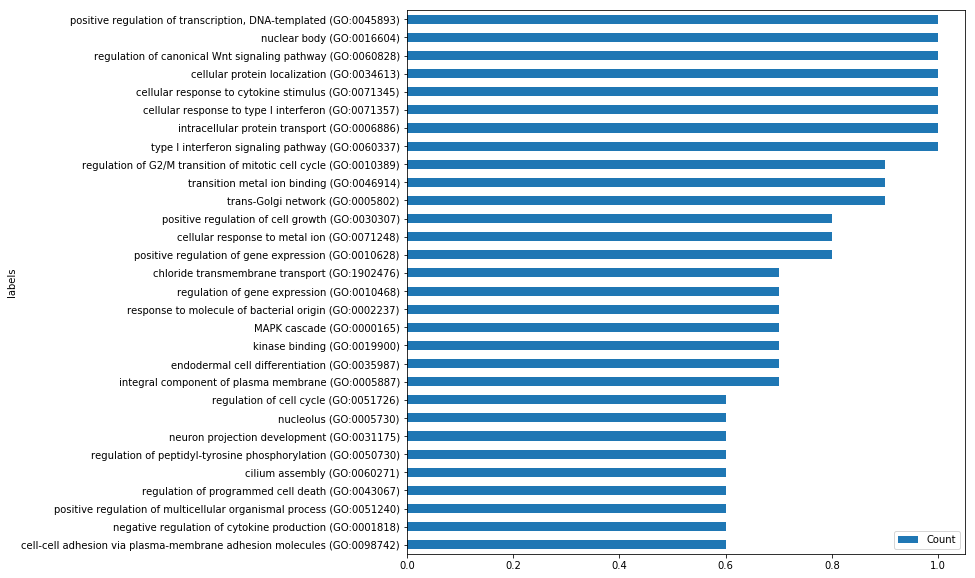

In [155]:
ax = lambdas.plot.barh(x='labels', y='Count', figsize=(10,10))

In [118]:
usage_dict = {"100% Usage": [0], "50% Usage": [0], "25% Usage": [0], "Total": [len(lambda_counts)]}
for val in lambda_counts.values:
    if val[0] == 10: usage_dict["100% Usage"][0] += 1
    elif val[0] > 5: usage_dict["50% Usage"][0] += 1
    elif val[0] > 2.5: usage_dict["25% Usage"][0] += 1

In [119]:
usage_df = pd.DataFrame(usage_dict, index=[''])
usage_df

,100% Usage,50% Usage,25% Usage,Total
,8,26,38,171


## Box Plot

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 25))

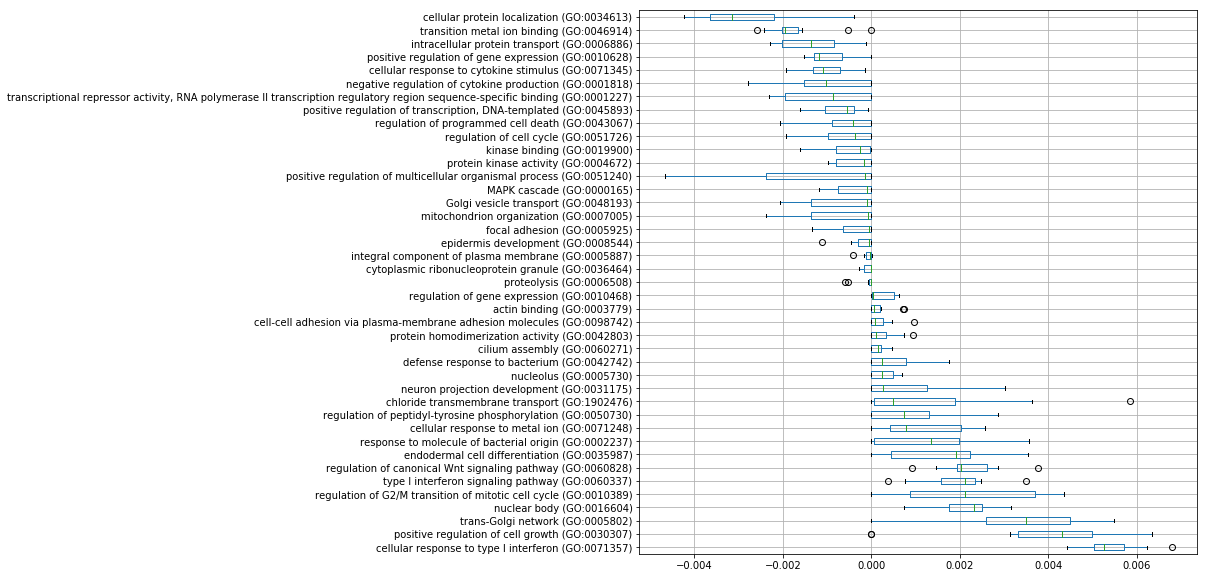

In [152]:
meds = summaries.median()
meds.sort_values(ascending=False, inplace=True)
meds = meds[meds != 0]
df2 = summaries[meds.index]
df2.boxplot(vert=False, rot=0, figsize=(10,10))